In [1]:
import pandas as pd
import pandasql as psql
from geopy.geocoders import Nominatim
import time
import numpy as np
from config import DATA_DIR
from geo_utils import load_lsoa_coordinates, get_patient_lat_long
from utils import estimate_slots_per_day_from_patient_data, generate_synthetic_patients



In [2]:
df_patient = pd.read_csv(DATA_DIR/ "Cataracts_RTT_Patient_level_data_24-25.csv")
df_provider = pd.read_csv(DATA_DIR/ "provider.csv")

In [3]:
df_patient.columns = df_patient.columns.str.strip().str.lower().str.replace(' ', '_')

print(df_patient.columns)
print(df_provider.columns)

Index(['provider', 'local_patient_identifier', 'lsoa', 'hrg_description',
       'fin_year', 'fin_month', 'start_clock_date', 'end_clock_date',
       'priority', 'independent_sector'],
      dtype='object')
Index(['Unnamed: 0', 'provider', 'is_nhs', 'ODScode', 'TrustName',
       'ITClocation', 'SlotsPerYear', 'SlotsPerWeek', 'SlotsPerDay',
       'NumberOfSurgeons', 'lat', 'long'],
      dtype='object')


In [4]:
if 'is_nhs' in df_patient.columns:
    df_patient = df_patient.drop(columns='is_nhs')

df_patient = df_patient.merge(
    df_provider[['provider', 'is_nhs']],
    how='left',
    on='provider'
)
df_patient['is_nhs'] = df_patient['is_nhs'].fillna(False)

df_patient['start_clock_date'] = pd.to_datetime(df_patient['start_clock_date'], errors='coerce')
df_patient['end_clock_date'] = pd.to_datetime(df_patient['end_clock_date'], errors='coerce')
df_patient['waiting_time'] = (df_patient['end_clock_date'] - df_patient['start_clock_date']).dt.days # calculate waiting time
df_patient['waiting_time'] = df_patient['waiting_time'].apply(
    lambda x: x if pd.notnull(x) and x >= 0 else np.nan
)


/var/folders/p_/9q2bvzqj04g1v63p4rjk_cxr0000gn/T/ipykernel_61310/3971728567.py:11: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_patient['start_clock_date'] = pd.to_datetime(df_patient['start_clock_date'], errors='coerce')
/var/folders/p_/9q2bvzqj04g1v63p4rjk_cxr0000gn/T/ipykernel_61310/3971728567.py:12: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_patient['end_clock_date'] = pd.to_datetime(df_patient['end_clock_date'], errors='coerce')


In [5]:
# HRG description -> code
HRG_DESC_TO_CODE = {
    'Complex, Cataract or Lens Procedures, with CC Score 2+': 'BZ30A',
    'Complex, Cataract or Lens Procedures, with CC Score 0-1': 'BZ30B',
    'Very Major, Cataract or Lens Procedures, with CC Score 2+': 'BZ31A',
    'Very Major, Cataract or Lens Procedures, with CC Score 0-1': 'BZ31B',
    'Intermediate, Cataract or Lens Procedures, with CC Score 2+': 'BZ32A',
    'Intermediate, Cataract or Lens Procedures, with CC Score 0-1': 'BZ32B',
    'Minor, Cataract or Lens Procedures': 'BZ33Z',
    'Phacoemulsification Cataract Extraction and Lens Implant, with CC Score 4+': 'BZ34A',
    'Phacoemulsification Cataract Extraction and Lens Implant, with CC Score 2-3': 'BZ34B',
    'Phacoemulsification Cataract Extraction and Lens Implant, with CC Score 0-1': 'BZ34C',
}

# HRG code -> category, cc_score, complexity
HRG_MAP = {
    'BZ30A': ('Complex', 'CC Score 2+', 'High'),
    'BZ30B': ('Complex', 'CC Score 0-1', 'Medium'),
    'BZ31A': ('Very Major', 'CC Score 2+', 'High'),
    'BZ31B': ('Very Major', 'CC Score 0-1', 'Medium'),
    'BZ32A': ('Intermediate', 'CC Score 2+', 'Medium'),
    'BZ32B': ('Intermediate', 'CC Score 0-1', 'Medium'),
    'BZ33Z': ('Minor', 'NA', 'Low'),
    'BZ34A': ('Phaco', 'CC Score 4+', 'High'),
    'BZ34B': ('Phaco', 'CC Score 2-3', 'Medium'),
    'BZ34C': ('Phaco', 'CC Score 0-1', 'Low'),
}

def assign_hrg_and_complexity(df_patient):
    df = df_patient.copy()

    df['hrg_code'] = df['hrg_description'].map(HRG_DESC_TO_CODE)

    df[['category', 'cc_score', 'complexity']] = df['hrg_code'].apply(
    lambda code: pd.Series(HRG_MAP.get(code, ('NA', 'NA', 'Unknown')))
    )

    return df


df_patient = assign_hrg_and_complexity(df_patient)

In [6]:
estimated_slots = estimate_slots_per_day_from_patient_data(df_patient)

df_provider_filled = df_provider.copy()


for col in ['SlotsPerDay', 'SlotsPerWeek', 'SlotsPerYear']:
    if col in df_provider_filled.columns:
        mask_na = df_provider_filled[col].isna()
        df_provider_filled.loc[mask_na, col] = df_provider_filled.loc[mask_na, 'provider'].map(
            estimated_slots.set_index('provider')[col]
        )
    else:
        df_provider_filled[col] = df_provider_filled['provider'].map(
            estimated_slots.set_index('provider')[col]
        )

df_provider_cleaned = df_provider_filled[[
    'provider',
    'is_nhs',
    'SlotsPerYear',
    'SlotsPerWeek',
    'SlotsPerDay',
    'lat',
    'long'
]]

active_providers = df_patient['provider'].unique()
df_provider_cleaned = df_provider_cleaned[df_provider_cleaned['provider'].isin(active_providers)].reset_index(drop=True)

df_provider_cleaned.to_csv('./data/provider_lat_long.csv', index=False)


In [7]:
np.random.seed(42)
df_patient['needs_ga'] = np.random.rand(len(df_patient)) < 0.05

In [8]:
df_patient = get_patient_lat_long(df_patient, load_lsoa_coordinates())
df_patient = df_patient[df_patient['lat'].notnull() & df_patient['long'].notnull()]

In [9]:
df_incentive = pd.read_csv("./data/nhs_tariff.csv")

tariff_map = df_incentive.set_index('hrg_code')['tariff'].to_dict()
df_patient['tariff'] = df_patient['hrg_code'].map(tariff_map)
df_patient['has_tariff'] = df_patient['tariff'].notna()

df_with_tariff = df_patient[df_patient['has_tariff']]
df_without_tariff = df_patient[~df_patient['has_tariff']]

# estimate
fallback_tariff = {
    'BZ34A': 1300, 
    'BZ34B': 950,
    'BZ34C': 850
}

df_patient['tariff'] = df_patient.apply(
    lambda row: fallback_tariff.get(row['hrg_code'], row['tariff']),
    axis=1
)

df_patient.to_csv('./data/patient_lat_long.csv')

In [10]:
df_historical = pd.read_csv('./data/patient_lat_long_old.csv')

if "hrg" in df_historical.columns:
    df_historical = df_historical.rename(columns={"hrg": "hrg_code"})

df_historical = df_historical[~df_historical["local_patient_identifier"].astype(str).str.startswith("synthetic_")]

columns_to_drop = [
    "independent_sector", "provider_type", "hrg_type", "cc_score", 
    "needs_ga", "synthetic_location", "activity_date", "activity_type", "hrg_description"
]

df_historical = df_historical.drop(columns=[col for col in columns_to_drop if col in df_historical.columns])

df_synthetic = generate_synthetic_patients(
    df_historical=df_historical,
    df_2425=df_patient,
    df_providers_2425=df_provider_cleaned,
    n=28000,
    date_range=("2024-04-01", "2025-03-31"),
    ga_ratio=0.02
)

df_synthetic["waiting_time"] = df_synthetic["waiting_time"].round().astype("Int64")

df_synthetic['tariff'] = df_synthetic['hrg_code'].map(tariff_map)
df_synthetic['has_tariff'] = df_synthetic['tariff'].notna()

df_with_tariff = df_synthetic[df_synthetic['has_tariff']]
df_without_tariff = df_synthetic[~df_synthetic['has_tariff']]

df_synthetic['tariff'] = df_synthetic.apply(
    lambda row: fallback_tariff.get(row['hrg_code'], row['tariff']),
    axis=1
)

def enrich_hrg_details(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # HRG Description (reverse mapping)
    CODE_TO_DESC = {v: k for k, v in HRG_DESC_TO_CODE.items()}

    # สร้าง column ใหม่
    df["hrg_description"] = df["hrg_code"].map(CODE_TO_DESC)
    df[["category", "cc_score", "complexity"]] = df["hrg_code"].apply(
        lambda code: pd.Series(HRG_MAP.get(code, ("Unknown", "Unknown", "Unknown")))
    )

    return df

df_synthetic = enrich_hrg_details(df_synthetic)

df_synthetic.to_csv('df_synthetic.csv')

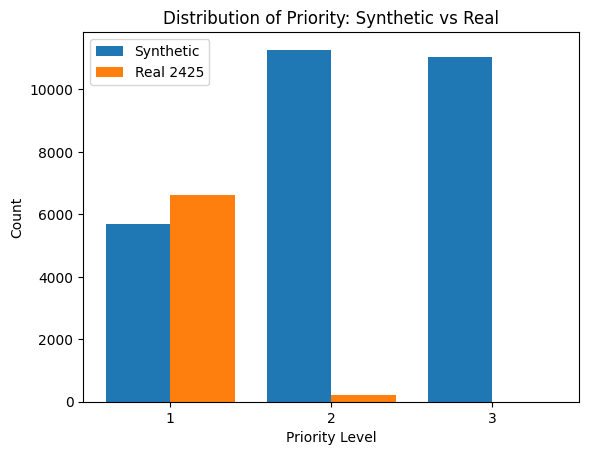

In [11]:
import matplotlib.pyplot as plt

counts_synthetic = df_synthetic["priority"].value_counts().sort_index()
counts_real = df_patient["priority"].value_counts().sort_index()

plt.bar(counts_synthetic.index - 0.2, counts_synthetic.values, width=0.4, label='Synthetic')
plt.bar(counts_real.index + 0.2, counts_real.values, width=0.4, label='Real 2425')
plt.xticks([1, 2, 3])
plt.xlabel("Priority Level")
plt.ylabel("Count")
plt.legend()
plt.title("Distribution of Priority: Synthetic vs Real")
plt.show()


In [12]:
df_synthetic["priority"].value_counts(normalize=True)

priority
2    0.402643
3    0.393964
1    0.203393
Name: proportion, dtype: float64

In [13]:
df_patient["source"] = "real"
df_synthetic["source"] = "synthetic"
df_combined = pd.concat([df_patient, df_synthetic], ignore_index=True)
df_combined.to_csv('./data/patient_lat_long.csv')

/var/folders/p_/9q2bvzqj04g1v63p4rjk_cxr0000gn/T/ipykernel_61310/3029084668.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


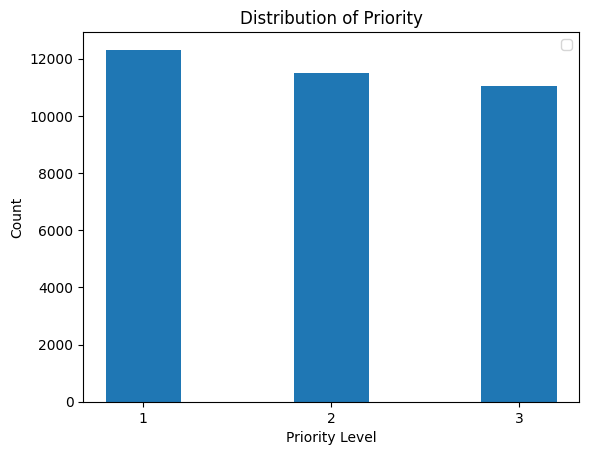

priority
1    0.353356
2    0.329937
3    0.316706
Name: proportion, dtype: float64

In [14]:
df_combined["priority"].value_counts(normalize=True)
counts = df_combined["priority"].value_counts().sort_index()

plt.bar(counts.index, counts.values, width=0.4)
plt.xticks([1, 2, 3])
plt.xlabel("Priority Level")
plt.ylabel("Count")
plt.legend()
plt.title("Distribution of Priority")
plt.show()

df_combined["priority"].value_counts(normalize=True)